
# **RUL Prediction on CMapss Data**

Dataset: https://www.kaggle.com/behrad3d/nasa-cmaps


# C-MAPSS Dataset

## Load Dataset

In [5]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
from matplotlib import pyplot
from google.colab import drive
drive.mount('/content/drive')

sequence_length = 30

Mounted at /content/drive


In [6]:
def add_columns():
    """
    Add all avaliable feature names for dataset
    """
    columns = ['unit_number', 'time_in_cycles']
    for i in range(1,4):
        columns = columns + ['operational_setting_' + str(i)] 
    for i in range(1,24):
        columns = columns + ['sensor_measurement_' + str(i)] 
    #print(columns)
    print("Column length: ",len(columns))
    return columns

In [7]:
def lifes_cycles(dataset):
  """
  Look max, min, mean life in cycles for dataset
  """
  cycles_limit=[dataset.groupby('unit_number').max()['time_in_cycles']]
  cycles_limit = np.asarray(cycles_limit)
  print("Cycles Limits >> ", cycles_limit)
  print("Max Life >> ",np.max(cycles_limit))
  print("Mean Life >> ",np.mean(cycles_limit))
  print("Min Life >> ",np.min(cycles_limit))

In [8]:
def drop_features(dataset):
    """
    Create a list to drop some features which has null or constant values
    """

    dataset_np = dataset.to_numpy()

    # drop features that are constant 
    drop_list = [2,3,4]
    for i in range(5,28):
      unique_count=len(np.unique(dataset_np[:,i]))
      if unique_count<5 or np.isnan(dataset_np[:,i]).all():
          drop_list.append(i)
    print("Removed column size: ",len(drop_list))

    return drop_list

## Preprocessing
*As a widely investigated dataset in the related researches, the
sub-dataset 1, which includes one operational condition and one fault mode, i.e. HPC degra-
dation, is used in the case studies in this paper.
Some sensor readings have constant outputs in the engine’s
lifetime and they do not provide valuable information for RUL estimation. Therefore, 14
sensor measurements out of the total 21 sensors are used as the raw input features*

It should be noted that the normalized data, which
are prepared in 2D format, are used directly as the model input.No hand-crafted signal
processing feature is needed, such as skewness, kurtosis etc. Therefore, no prior expertise on
prognostics and signal processing is required in the proposed method.


In [9]:
from sklearn.preprocessing import MinMaxScaler 

In [10]:
def prepare_data(data, factor = 0):
    """
    Create Rul labels using time_in_cycles feature.
    """
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]

In [11]:
def preprocess(dataset,drop_list, scaler):
    """
    Drop features according to drop_list, normalize sensors and create new dataframe
    """
    columns = dataset.columns
    dataset_np = dataset.to_numpy()
    dataset_dropped = np.delete(dataset_np, drop_list, axis=1) 
    print("New shape of train data: ",dataset_dropped.shape)

    # Min-max normalization(StandardScaler() will normalize the features i.e. each column of X)
    dataset_normalized=scaler.transform(dataset_dropped[:,2:-1])  

    # combine unit_name and times_in_cycles features with normalized data
    dataset_df = pd.concat([pd.DataFrame(data=dataset_dropped[:,:2]), pd.DataFrame(data=dataset_normalized)], axis=1, sort=False)
    dataset_df['RUL']=dataset_dropped[:,-1]

    # get new column names for new df
    new_columns = [columns[idx_col] for idx_col in range(len(columns)) if idx_col not in drop_list]
    dataset_df.columns=new_columns

    return dataset_df


## Time Window Processing

In [12]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def gen_sequence(id_df, seq_length, seq_cols):
    """
    Function to reshape features into (samples, time steps, features)
    Only sequences that meet the window-length are considered, no padding is used. 
    """

    # for one unit, put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 30
    # so zip iterate over two following list of numbers (0,162),(30,192)
    # 0 30 -> from row 0 to row 30
    # 1 31 -> from row 1 to row 31
    # 2 32 -> from row 2 to row 32
    # ...
    # 161 191 -> from row 161 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        

In [14]:
def gen_labels(id_df, seq_length, r_early):
    """ 
    Function to generate labels
    Only sequences that meet the window-length are considered, no padding is used. 
    After this, r-early is applied
    """
    
    y = id_df[['RUL']].values
    num_elements = y.shape[0]

    y=y[seq_length:num_elements, :]

    # use R-early
    y[y > r_early] = r_early
    # https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb 
    return y


In [15]:
def time_window_processing(data_df, sequence_length = 30):
    """
    Generate sequence data and their labels
    """
    # pick the feature columns 
    sequence_cols = list(data_df.columns)
    # drop RUL column
    sequence_cols = sequence_cols[2:-1]
    print("Columns: ", sequence_cols)

    # generator for the sequences
    # transform each id of the train dataset in a sequence
    seq_gen = (list(gen_sequence(data_df[data_df['unit_number']==id], sequence_length, sequence_cols)) 
               for id in data_df['unit_number'].unique())

    # generate sequences and convert to numpy array
    x = np.concatenate(list(seq_gen)).astype(np.float32)
    print("Train size: ",x.shape)

    # generate labels
    label_gen = [gen_labels(data_df[data_df['unit_number']==id], sequence_length, 125) 
                 for id in data_df['unit_number'].unique()]
    y = np.concatenate(label_gen).astype(np.float32)
    print(y.shape)
    return x,y, sequence_cols

## Train Data

In [16]:
# read training files
train_FD001 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CMaps/train_FD001.txt', sep=" ", header=None)
# train_FD001 = pd.read_csv('CMaps/train_FD001.txt', sep=" ", header=None)
train_FD001.columns = add_columns()
print(train_FD001)

Column length:  28
       unit_number  ...  sensor_measurement_23
0                1  ...                    NaN
1                1  ...                    NaN
2                1  ...                    NaN
3                1  ...                    NaN
4                1  ...                    NaN
...            ...  ...                    ...
20626          100  ...                    NaN
20627          100  ...                    NaN
20628          100  ...                    NaN
20629          100  ...                    NaN
20630          100  ...                    NaN

[20631 rows x 28 columns]


In [17]:
lifes_cycles(train_FD001)

Cycles Limits >>  [[192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
  158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
  170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
  193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
  213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
  135 341 155 258 283 336 202 156 185 200]]
Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


In [18]:
train_FD001=prepare_data(train_FD001)

In [19]:
train_FD001

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,1


In [20]:
drop_list = drop_features(train_FD001)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.delete(train_FD001.to_numpy(), drop_list, axis=1)[:,2:-1])

Removed column size:  12


MinMaxScaler(copy=True, feature_range=(-1, 1))

In [21]:
train_df = preprocess(train_FD001, drop_list, scaler)

New shape of train data:  (20631, 17)


In [22]:
train_df

,unit_number,time_in_cycles,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,RUL
0,1.0,1.0,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-5.882353e-01,-0.600784,-0.272028,-0.333333,0.426357,0.449323,191.0
1,1.0,2.0,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-4.411765e-01,-0.674373,-0.177376,-0.333333,0.333333,0.462027,190.0
2,1.0,3.0,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-5.588235e-01,-0.656414,-0.285110,-0.666667,0.255814,0.242751,189.0
3,1.0,4.0,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-4.117647e-01,-0.650222,-0.666795,-0.333333,0.147287,0.324772,188.0
4,1.0,5.0,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-5.294118e-01,-0.650532,-0.195845,-0.166667,0.178295,0.409003,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100.0,196.0,0.373494,0.174624,0.565834,-0.491143,-0.121212,-0.607018,0.452381,-0.658849,1.176471e-01,-0.611312,0.313582,0.500000,-0.457364,-0.781000,4.0
20627,100.0,197.0,0.403614,0.458906,0.732951,-0.674718,0.000000,-0.610697,0.416667,-0.577825,-9.094947e-13,-0.622665,0.454406,0.166667,-0.751938,-0.267606,3.0
20628,100.0,198.0,0.331325,0.369959,0.550641,-0.648953,0.030303,-0.603608,0.476190,-0.437100,5.882353e-02,-0.575704,0.844556,0.666667,-0.534884,-0.892019,2.0
20629,100.0,199.0,0.216867,0.492043,0.494936,-0.732689,0.060606,-0.533429,0.833333,-0.582090,2.941176e-02,-0.593869,0.646787,0.166667,-0.767442,-0.531069,1.0


In [23]:
x_train, y_train, sequence_cols = time_window_processing(train_df)

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)


## Test

In [24]:
test_FD001 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CMaps/test_FD001.txt', sep=" ", header=None)
RUL_FD001 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CMaps/RUL_FD001.txt', sep=" ", header=None)
# test_FD001 = pd.read_csv('CMaps/test_FD001.txt', sep=" ", header=None)
# RUL_FD001 = pd.read_csv('CMaps/RUL_FD001.txt', sep=" ", header=None)
test_FD001.columns = add_columns()
print(test_FD001.shape)
print(RUL_FD001.shape)

Column length:  28
(13096, 28)
(100, 2)


In [25]:
lifes_cycles(test_FD001)

Cycles Limits >>  [[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
  135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
  121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
  113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
  112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
  234 150 244 133  89  97 134 121  97 198]]
Max Life >>  303
Mean Life >>  130.96
Min Life >>  31


In [26]:
test_FD001 = prepare_data(test_FD001)

In [27]:
test_df = preprocess(test_FD001, drop_list, scaler)

New shape of train data:  (13096, 17)


In [28]:
test_df

,unit_number,time_in_cycles,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,RUL
0,1.0,1.0,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.735680,-0.382070,-0.333333,0.116279,0.323667,30.0
1,1.0,2.0,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.590463,-0.573682,-0.166667,0.364341,0.373654,29.0
2,1.0,3.0,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.688719,-0.082724,-0.166667,0.457364,0.442695,28.0
3,1.0,4.0,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.659820,-0.485956,-0.500000,0.333333,0.324220,27.0
4,1.0,5.0,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.694499,-0.398230,-0.666667,0.317829,0.432753,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,0.222892,0.238718,0.132343,0.146538,-0.636364,0.082653,0.000000,-0.147122,-0.647059,0.169780,0.128126,0.000000,-0.209302,-0.162662,4.0
13092,100.0,195.0,0.210843,0.074777,0.343687,0.085346,-0.545455,0.067486,-0.107143,0.006397,-0.382353,0.144700,-0.028088,0.166667,-0.333333,0.057443,3.0
13093,100.0,196.0,0.343373,-0.035971,-0.170493,0.027375,-0.363636,0.122498,-0.142857,0.061834,-0.529412,0.210651,0.015775,0.166667,-0.255814,-0.141397,2.0
13094,100.0,197.0,0.234940,0.044256,0.252870,0.133655,-0.484848,0.140806,-0.095238,0.125800,-0.411765,0.244091,0.125048,0.166667,-0.193798,0.037559,1.0


# Models

*The proposed deep learning framework is able to provide a systematic and accurate method
of prognostics. In order to show the superiority of the proposed method to existing popular
methods, its testing performance is compared with those of other network architectures in
this paper. Different prognostic methods for RUL estimation are carried out, including basic
neural network (NN), deep neural network (DNN), recurrent neural network (RNN) and long
short-term memory (LSTM).*

*For all the comparing methods in this study, the input and output layers are the same with
the proposed network, and RMSE is used as the loss function. Back-propagation is employed
for the updates of model parameters where the Adam optimization algorithm is used.*

In [30]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ReduceLROnPlateau
import keras
from keras.layers import Dense, Conv1D, LSTM, SimpleRNN, Flatten, Dropout, Activation
from keras.initializers import glorot_uniform # Xavier normal initializer
from keras import backend as K
from matplotlib import pyplot as plt
import math

from datetime import datetime

## Performance Metrics

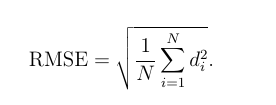

In [31]:
def root_mean_squared_error(y_true, y_pred):
    """
    Loss function
    """
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

image.png

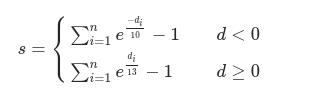

In [32]:
def competitive_score(y_true,y_pred):
    """
    Error Function for Competitive Data
    """
    y_error = y_pred - y_true
    bool_idx = K.greater(y_error, 0)
    loss1 = K.exp(-1*y_error/13) - 1 # greater 0
    loss2 = K.exp(y_error/10) - 1    # less 0
    loss = K.switch(bool_idx, loss2, loss1)
    return K.sum(loss)

In [33]:
def plot_history(model, history):
    # training metrics
    scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
    print('RMSE: {}'.format(scores[1]))
    
    # summarize history for R^2
    fig_acc = plt.figure(figsize=(5, 5))
    plt.plot(history.history['competitive_score'])
    plt.plot(history.history['val_competitive_score'])
    plt.title('Competitive_score')
    plt.ylabel('Competitive score')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for RMSE
    fig_acc = plt.figure(figsize=(5, 5))
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_rmse.png")

## Evaluation

In [34]:
def plot_compare_pred(y_pred, y_true):
    """
    Plot in red color the predicted data and in green color the
    actual data to verify visually the accuracy of the model.
    """
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred, color="red")
    plt.plot(y_true, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    # fig_verify.savefig("model_regression_verify.png")

In [35]:
def predict_test(model, test_df, label_df, sequence_cols, sequence_length=30):
    """
    Do prediction on model
    """
    y_true = label_df[0].to_numpy()
    y_true = np.asarray(y_true.reshape(y_true.shape[0],-1)).astype(float)
    print(y_true.shape)
    # We pick the last sequence for each id in the test data
    seq_array_test_last = [test_df[test_df['unit_number']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['unit_number'].unique() if len(test_df[test_df['unit_number']==id]) >= sequence_length]
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    print(seq_array_test_last.shape)
    # test metrics

    score = model.evaluate(seq_array_test_last, y_true, verbose=2)
    print('\nRMSE: {}'.format(score[1]))
    print('\nScore: {}'.format(score[2]))
    y_pred = model.predict(seq_array_test_last)
    plot_compare_pred(y_pred,y_true)
    return score[1], score[2]

## DCNN



*Back-propagation learning is used for the updates of the weights in the network. The Adam
optimization algorithm is used with mini-batches for the updates. For each training epoch,
the samples are randomly divided into multiple mini-batches with each batch containing 512
samples, and put into the training system. Next, the network information, i.e. the weights
in each layer, are optimized based on the mean loss function of each mini-batch. It should
be noted that the selection of batch size affects the network training performance. The
batch size of 512 samples is found appropriate based on the experiments and it is used in all
the case studies in this paper.*


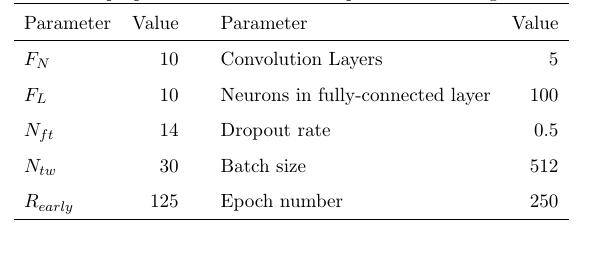

In [ ]:
model_dcnn = Sequential()#add model layers
model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same", input_shape=(sequence_length, x_train.shape[2])))
model_dcnn.add(Dropout(0.5))
model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn.add(Dropout(0.5))
model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn.add(Dropout(0.5))
model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn.add(Dropout(0.5))
model_dcnn.add(Conv1D(1, kernel_size=3, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn.add(Flatten())
model_dcnn.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
model_dcnn.add(Dense(y_train.shape[1]))
model_dcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 10)            1410      
_________________________________________________________________
dropout (Dropout)            (None, 30, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 10)            1010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 10)            1010      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 10)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 10)            1

In [ ]:
#compile model using accuracy to measure model performance
model_dcnn.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])

In [ ]:
#train the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=200, min_lr=0.0001)
start=datetime.now()
history_dcnn = model_dcnn.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr])
dcnn_training_time = datetime.now()-start

Epoch 1/250
33/33 [==============================] - 4s 24ms/step - loss: 89.1659 - root_mean_squared_error: 89.1628 - competitive_score: 2472191.9559 - val_loss: 81.7754 - val_root_mean_squared_error: 80.6820 - val_competitive_score: 1134208.2500
Epoch 2/250
33/33 [==============================] - 0s 5ms/step - loss: 80.6642 - root_mean_squared_error: 80.6633 - competitive_score: 1166833.5074 - val_loss: 75.7620 - val_root_mean_squared_error: 74.7173 - val_competitive_score: 659662.6250
Epoch 3/250
33/33 [==============================] - 0s 5ms/step - loss: 74.8124 - root_mean_squared_error: 74.8115 - competitive_score: 696812.5478 - val_loss: 71.7638 - val_root_mean_squared_error: 70.7554 - val_competitive_score: 456496.9688
Epoch 4/250
33/33 [==============================] - 0s 5ms/step - loss: 71.5436 - root_mean_squared_error: 71.5433 - competitive_score: 500652.4007 - val_loss: 68.3623 - val_root_mean_squared_error: 67.3886 - val_competitive_score: 332184.9062
Epoch 5/250
33/3

89/89 [==============================] - 0s 3ms/step - loss: 12.5914 - root_mean_squared_error: 12.5420 - competitive_score: 731.6161
RMSE: 12.541988372802734


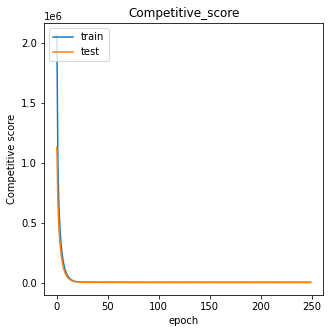

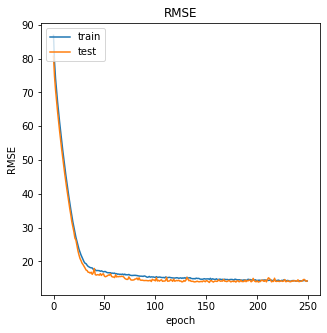

In [ ]:
plot_history(model_dcnn,history_dcnn)

(100, 1)
(100, 30, 14)
4/4 - 0s - loss: 16.8694 - root_mean_squared_error: 16.9440 - competitive_score: 162.8658

RMSE: 16.944002151489258

Score: 162.86575317382812


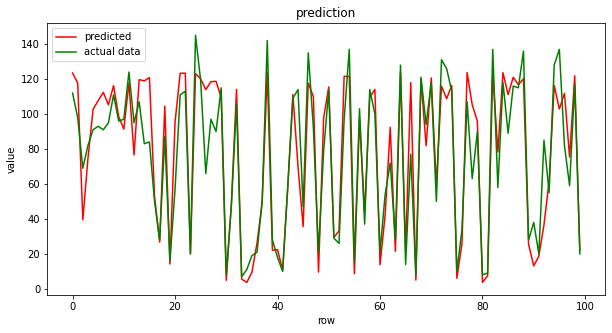

In [ ]:
dcnn_score, dcnn_comp_score=predict_test(model_dcnn,test_df, RUL_FD001, sequence_cols)

## NN

*The basic neural network, which is also known as multi-layer perceptron (MLP), is used for comparison, which has 1 hidden layer of 500 neurons. Dropout rate of 0.5 and a softmax classifier are applied.*


In [ ]:
model_nn = Sequential()#add model layers
model_nn.add(Dense(500, activation='softmax', kernel_initializer=glorot_uniform, input_shape=(sequence_length, x_train.shape[2])))
model_nn.add(Dropout(0.5))
model_nn.add(Flatten())
model_nn.add(Dense(y_train.shape[1]))
model_nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30, 500)           7500      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 500)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 15001     
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#compile model using accuracy to measure model performance
#adam = keras.optimizers.Adam(learning_rate=0.0001)
model_nn.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])

In [ ]:
#train the model
start=datetime.now()
history_nn = model_nn.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr])
nn_training_time = datetime.now()-start

Epoch 1/250
33/33 [==============================] - 1s 17ms/step - loss: 90.1784 - root_mean_squared_error: 90.1789 - competitive_score: 2737227.5588 - val_loss: 89.3619 - val_root_mean_squared_error: 88.2190 - val_competitive_score: 2212031.0000
Epoch 2/250
33/33 [==============================] - 0s 12ms/step - loss: 89.6255 - root_mean_squared_error: 89.6237 - competitive_score: 2563159.4265 - val_loss: 88.4314 - val_root_mean_squared_error: 87.2941 - val_competitive_score: 2039275.0000
Epoch 3/250
33/33 [==============================] - 0s 12ms/step - loss: 88.3951 - root_mean_squared_error: 88.3949 - competitive_score: 2319048.9338 - val_loss: 87.4458 - val_root_mean_squared_error: 86.3151 - val_competitive_score: 1869356.5000
Epoch 4/250
33/33 [==============================] - 0s 12ms/step - loss: 87.3935 - root_mean_squared_error: 87.3935 - competitive_score: 2137807.8860 - val_loss: 86.3841 - val_root_mean_squared_error: 85.2609 - val_competitive_score: 1700753.2500
Epoch 5/

89/89 [==============================] - 0s 3ms/step - loss: 18.1032 - root_mean_squared_error: 17.9598 - competitive_score: 2287.7268
RMSE: 17.959774017333984


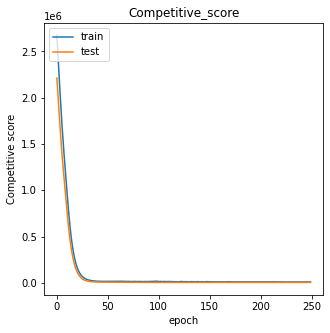

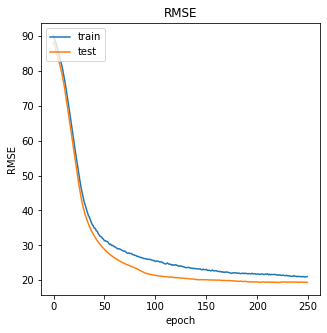

In [ ]:
plot_history(model_nn,history_nn)

(100, 1)
(100, 30, 14)
4/4 - 0s - loss: 19.6189 - root_mean_squared_error: 18.2630 - competitive_score: 275.2862

RMSE: 18.263004302978516

Score: 275.28619384765625


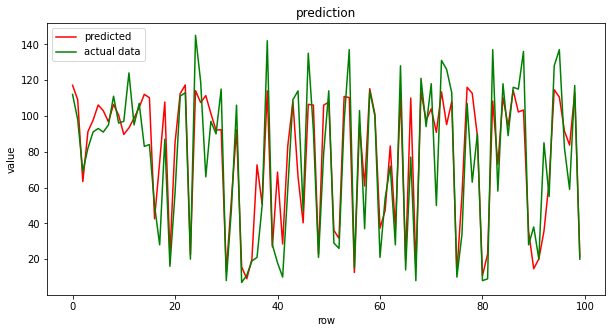

In [ ]:
nn_score, nn_comp_score = predict_test(model_nn,test_df, RUL_FD001,sequence_cols)

## DNN

*The deep neural network has 4 hidden layers. The number of neurons in the hidden
layers is 500, 400, 300 and 100, respectively. Dropout is employed in each hidden layer.*


In [ ]:
model_dnn = Sequential()#add model layers
model_dnn.add(Dense(500, activation='tanh', kernel_initializer=glorot_uniform, input_shape=(sequence_length, x_train.shape[2])))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(400, activation='tanh', kernel_initializer=glorot_uniform))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(300, activation='tanh', kernel_initializer=glorot_uniform))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
model_dnn.add(Dropout(0.5))
model_dnn.add(Flatten())
model_dnn.add(Dense(y_train.shape[1]))
model_dnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30, 500)           7500      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 500)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 30, 400)           200400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 30, 300)           120300    
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 300)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 30, 100)          

In [ ]:
#compile model using accuracy to measure model performance
adam = keras.optimizers.Adam(learning_rate=0.0001)
model_dnn.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])

In [ ]:
#train the model
start=datetime.now()
history_dnn = model_dnn.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr])
dnn_training_time = datetime.now()-start

Epoch 1/250
33/33 [==============================] - 2s 33ms/step - loss: 71.3786 - root_mean_squared_error: 71.3694 - competitive_score: 1133094.3079 - val_loss: 36.5427 - val_root_mean_squared_error: 36.9057 - val_competitive_score: 49944.7031
Epoch 2/250
33/33 [==============================] - 1s 21ms/step - loss: 35.3118 - root_mean_squared_error: 35.3109 - competitive_score: 54359.7698 - val_loss: 33.1625 - val_root_mean_squared_error: 33.0550 - val_competitive_score: 13281.8838
Epoch 3/250
33/33 [==============================] - 1s 22ms/step - loss: 28.4531 - root_mean_squared_error: 28.4519 - competitive_score: 9870.7608 - val_loss: 22.5377 - val_root_mean_squared_error: 22.6965 - val_competitive_score: 8322.6504
Epoch 4/250
33/33 [==============================] - 1s 21ms/step - loss: 22.5977 - root_mean_squared_error: 22.5978 - competitive_score: 8697.1789 - val_loss: 23.7965 - val_root_mean_squared_error: 24.1738 - val_competitive_score: 13406.6787
Epoch 5/250
33/33 [======

89/89 [==============================] - 0s 4ms/step - loss: 7.6299 - root_mean_squared_error: 7.6584 - competitive_score: 249.5584
RMSE: 7.658431529998779


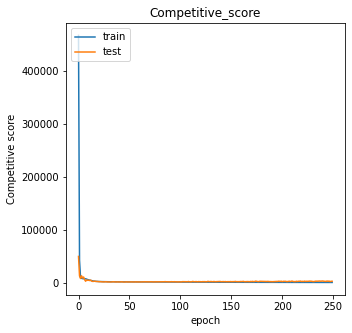

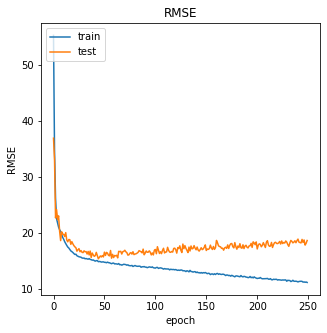

In [ ]:
plot_history(model_dnn,history_dnn)

(100, 1)
(100, 30, 14)
4/4 - 0s - loss: 18.4068 - root_mean_squared_error: 18.7883 - competitive_score: 200.6305

RMSE: 18.788286209106445

Score: 200.63046264648438


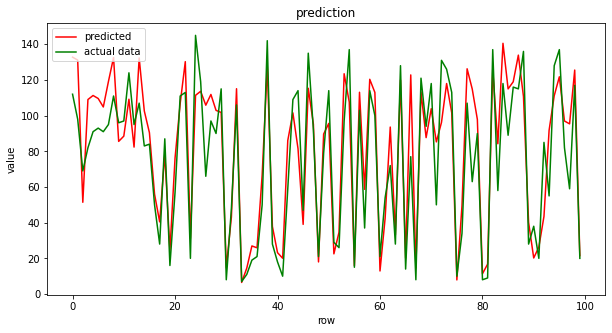

In [ ]:
dnn_score, dnn_comp_score = predict_test(model_dnn,test_df, RUL_FD001,sequence_cols)

## RNN

*The recurrent neural network contains feedback connections from the hidden or out-
put layers to the preceding layers, thus having the ability of processing dynamic
information. RNN is a more effective model that involves time-series data. Instead of
using the convolution layers in the proposed DCNN for further feature extraction, we
adopt 5 recurrent layers in the RNN network for comparison. In this way, the two
methods have the same depth. A fully-connected layer is also attached in order to have
similar architecture with the proposed method.*

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(10, activation='tanh', kernel_initializer=glorot_uniform, input_shape=(sequence_length, x_train.shape[2]), return_sequences=True, unroll=True))
model_rnn.add(Dropout(0.5))
model_rnn.add(SimpleRNN(10, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True, unroll=True))
model_rnn.add(Dropout(0.5))
model_rnn.add(SimpleRNN(10, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True, unroll=True))
model_rnn.add(Dropout(0.5))
model_rnn.add(SimpleRNN(10, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True, unroll=True))
model_rnn.add(Dropout(0.5))
model_rnn.add(SimpleRNN(1, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True, unroll=True))
model_rnn.add(Flatten())
model_rnn.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
model_rnn.add(Dense(y_train.shape[1]))
model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 10)            250       
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 10)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30, 10)            210       
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 10)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 30, 10)            210       
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 10)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 30, 10)           

In [ ]:
model_rnn.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])

In [ ]:
start=datetime.now()
history_rnn = model_rnn.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr])
rnn_training_time = datetime.now()-start
print(history_rnn.history.keys())

Epoch 1/250
33/33 [==============================] - 8s 59ms/step - loss: 90.2489 - root_mean_squared_error: 90.2474 - competitive_score: 2709529.2500 - val_loss: 83.3638 - val_root_mean_squared_error: 82.2598 - val_competitive_score: 1304240.1250
Epoch 2/250
33/33 [==============================] - 1s 23ms/step - loss: 84.0369 - root_mean_squared_error: 84.0346 - competitive_score: 1627843.2279 - val_loss: 74.7848 - val_root_mean_squared_error: 73.7507 - val_competitive_score: 600428.7500
Epoch 3/250
33/33 [==============================] - 1s 22ms/step - loss: 74.2254 - root_mean_squared_error: 74.2243 - competitive_score: 660905.8107 - val_loss: 70.1982 - val_root_mean_squared_error: 69.2139 - val_competitive_score: 389889.1875
Epoch 4/250
33/33 [==============================] - 1s 22ms/step - loss: 69.7058 - root_mean_squared_error: 69.7048 - competitive_score: 423837.4577 - val_loss: 66.6654 - val_root_mean_squared_error: 65.7273 - val_competitive_score: 276665.6875
Epoch 5/250
3

89/89 [==============================] - 1s 8ms/step - loss: 13.7644 - root_mean_squared_error: 13.6982 - competitive_score: 656.4886
RMSE: 13.698169708251953


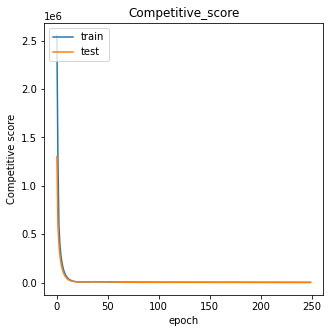

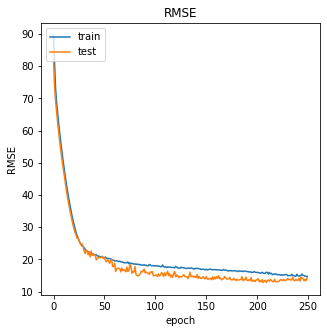

In [ ]:
plot_history(model_rnn, history_rnn)

(100, 1)
(100, 30, 14)
4/4 - 0s - loss: 16.3151 - root_mean_squared_error: 13.5468 - competitive_score: 133.6405

RMSE: 13.546770095825195

Score: 133.64053344726562


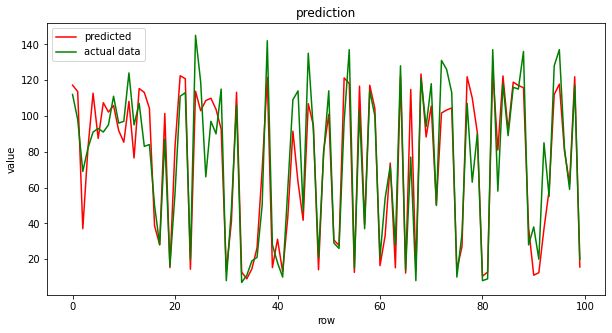

In [ ]:
rnn_score, rnn_comp_score = predict_test(model_rnn,test_df, RUL_FD001,sequence_cols)

## LSTM

*LSTM
Due to the vanishing gradient problem during back-propagation for model training,
traditional RNN may not capture long-term dependencies. Therefore, as a variant of
RNN, long-short term memory method is prefered by many researchers to prevent back-
propagated errors from vanishing or exploding. Gates are introduced in LSTM to
enable each recurrent unit to adaptively capture dependencies of different time scales.
In order to share similar structure with the proposed network, 5 LSTM layers and 1
fully-connected layer are used for comparison.*

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(10, activation='tanh',kernel_initializer=glorot_uniform, input_shape=(sequence_length, x_train.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(10, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(10, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(10, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(1, activation='tanh',kernel_initializer=glorot_uniform, return_sequences=True))
model_lstm.add(Flatten())
model_lstm.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
model_lstm.add(Dense(y_train.shape[1]))
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 10)            1000      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 10)            840       
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 10)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 10)            840       
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 10)           

In [ ]:
model_lstm.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])

In [ ]:
start=datetime.now()
history_lstm = model_lstm.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr])
lstm_training_time = datetime.now()-start
print(history_lstm.history.keys())

Epoch 1/250
33/33 [==============================] - 7s 57ms/step - loss: 89.5505 - root_mean_squared_error: 89.5485 - competitive_score: 2529849.6765 - val_loss: 82.5522 - val_root_mean_squared_error: 81.4532 - val_competitive_score: 1214216.6250
Epoch 2/250
33/33 [==============================] - 1s 20ms/step - loss: 81.1592 - root_mean_squared_error: 81.1587 - competitive_score: 1221532.4816 - val_loss: 75.6521 - val_root_mean_squared_error: 74.6098 - val_competitive_score: 650443.3750
Epoch 3/250
33/33 [==============================] - 0s 15ms/step - loss: 74.8285 - root_mean_squared_error: 74.8274 - competitive_score: 689923.2555 - val_loss: 71.4839 - val_root_mean_squared_error: 70.4846 - val_competitive_score: 440649.3750
Epoch 4/250
33/33 [==============================] - 0s 15ms/step - loss: 70.8793 - root_mean_squared_error: 70.8785 - competitive_score: 477392.4366 - val_loss: 68.0974 - val_root_mean_squared_error: 67.1397 - val_competitive_score: 318339.6562
Epoch 5/250
3

89/89 [==============================] - 1s 6ms/step - loss: 10.6893 - root_mean_squared_error: 10.6302 - competitive_score: 505.5802
RMSE: 10.630203247070312


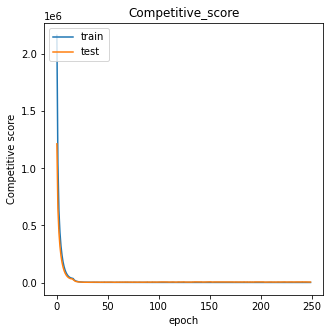

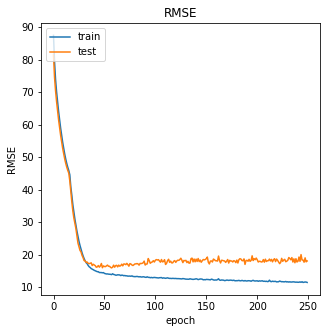

In [ ]:
plot_history(model_lstm, history_lstm)

(100, 1)
(100, 30, 14)
4/4 - 0s - loss: 16.5757 - root_mean_squared_error: 15.6253 - competitive_score: 136.0093

RMSE: 15.625287055969238

Score: 136.00929260253906


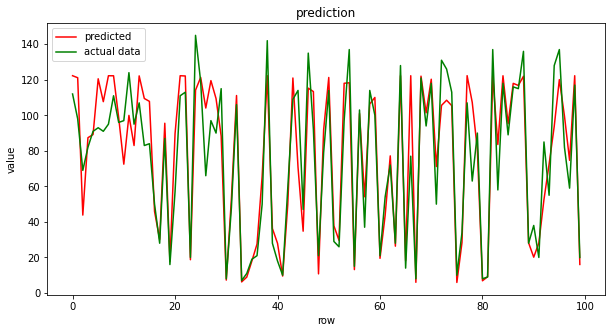

In [ ]:
lstm_score, lstm_comp_score = predict_test(model_lstm, test_df, RUL_FD001, sequence_cols)

## Compare Models

Paper results:

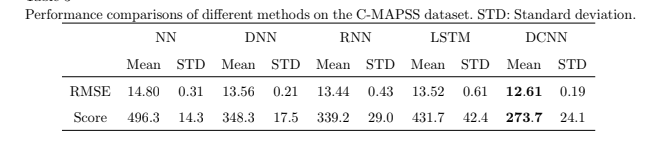

In [ ]:
def plot_model_comp_time(times, title):
  times = [nn_training_time, dnn_training_time, rnn_training_time,lstm_training_time, dcnn_training_time]
  times = [times[i].total_seconds() for i in range(0, len(times))]
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = ['NN', 'DNN', 'RNN', 'LSTM', 'DCNN']
  ax.bar(langs,times, color = ['grey', 'green', 'orange', 'yellow', 'blue'])
  ax.set_title(title)
  plt.show() 

In [ ]:
def plot_model_comp(scores, title):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = ['NN', 'DNN', 'RNN', 'LSTM', 'DCNN']
  ax.bar(langs,scores, color = ['grey', 'green', 'orange', 'yellow', 'blue'])
  ax.set_title(title)
  plt.show()

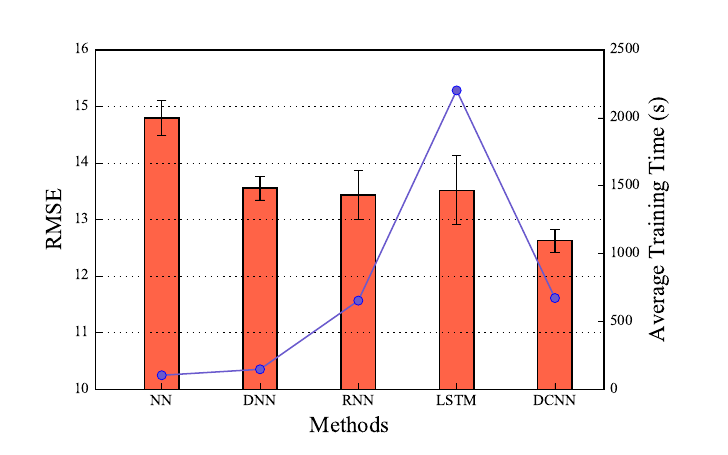

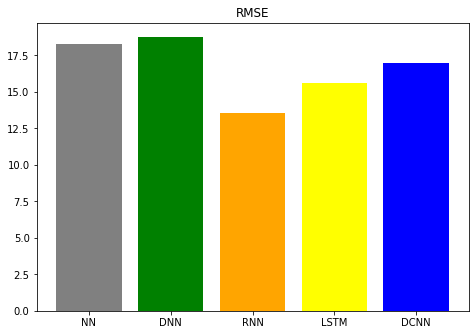

In [ ]:
plot_model_comp([nn_score, dnn_score, rnn_score, lstm_score, dcnn_score], 'RMSE')

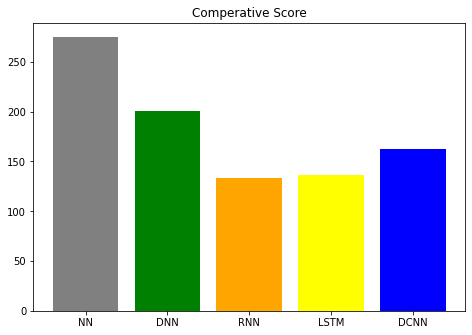

In [ ]:
plot_model_comp([nn_comp_score, dnn_comp_score, rnn_comp_score, lstm_comp_score, dcnn_comp_score], 'Comperative Score')

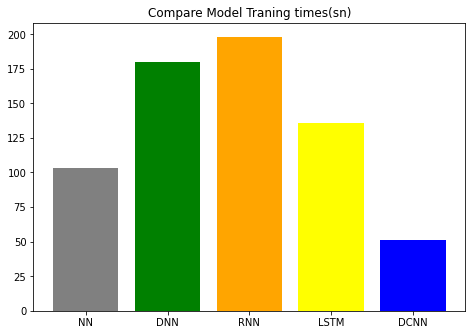

In [ ]:
times = [dnn_training_time,dnn_training_time,rnn_training_time,lstm_training_time, dcnn_training_time]
plot_model_comp_time(times, "Compare Model Traning times(sn)")

## Experiment

In [39]:
def plot_experiment_comp(sizes, rmse_scores, title):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(sizes,rmse_scores)
  ax.set_title(title)
  plt.show()

**Time window size**

In [47]:
sequence_lengths = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
rmse_scores = []
for seq in sequence_lengths:
    x_train, y_train, sequence_cols = time_window_processing(train_df, sequence_length=seq)
    K.clear_session()
    model_dcnn = Sequential()#add model layers
    model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same", input_shape=(seq, x_train.shape[2])))
    model_dcnn.add(Dropout(0.5))
    model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
    model_dcnn.add(Dropout(0.5))
    model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
    model_dcnn.add(Dropout(0.5))
    model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
    model_dcnn.add(Dropout(0.5))
    model_dcnn.add(Conv1D(1, kernel_size=3, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
    model_dcnn.add(Flatten())
    model_dcnn.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
    model_dcnn.add(Dense(y_train.shape[1])) 

    model_dcnn.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])   

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=200, min_lr=0.0001)
    history_dcnn = model_dcnn.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr],verbose=0)
    scores = model_dcnn.evaluate(x_train, y_train, verbose=1, batch_size=200)
    print('RMSE: {}'.format(scores[1]))
    rmse_scores.append(scores[1])


Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (20531, 1, 14)
(20531, 1)
103/103 [==============================] - 0s 2ms/step - loss: 19.6262 - root_mean_squared_error: 19.6087 - competitive_score: 4077.4946
RMSE: 19.60869026184082
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (20131, 5, 14)
(20131, 1)
101/101 [==============================] - 0s 2ms/s

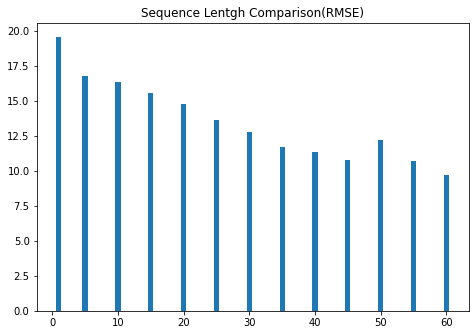

In [48]:
plot_experiment_comp(sequence_lengths, rmse_scores, "Sequence Lentgh Comparison(RMSE)")

**Number of Conv layer**

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (10096, 30, 14)
(10096, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 1)             141

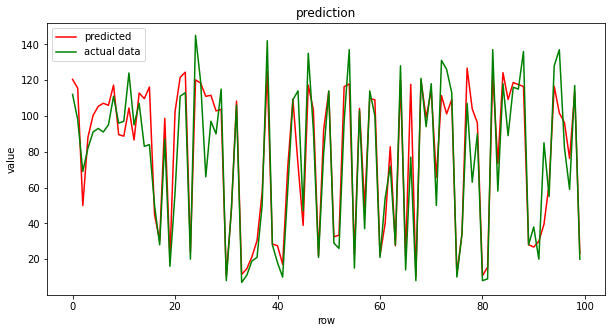

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (10096, 30, 14)
(10096, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 10)            141

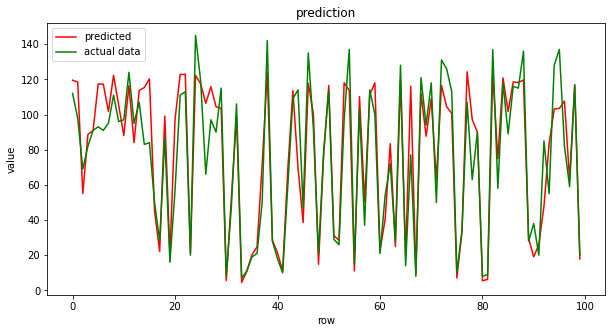

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (10096, 30, 14)
(10096, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 1)             141

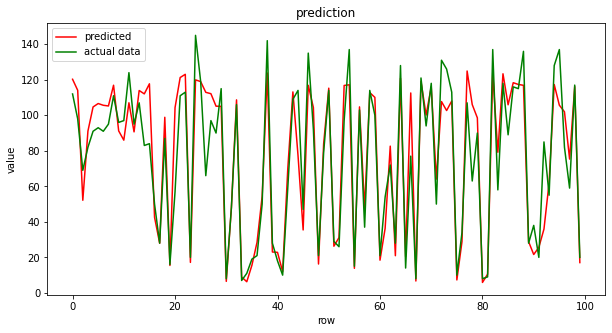

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (10096, 30, 14)
(10096, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 1)             141

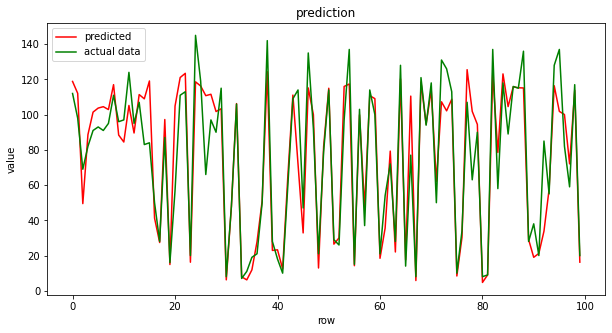

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (10096, 30, 14)
(10096, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 1)             141

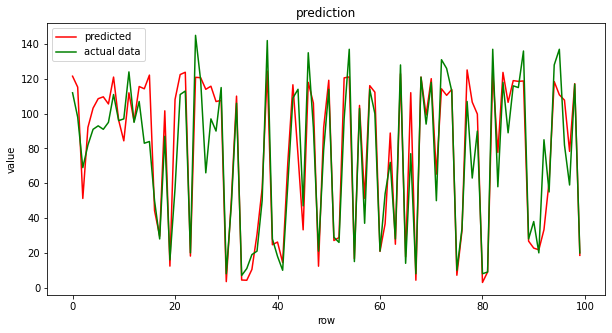

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (10096, 30, 14)
(10096, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 1)             141

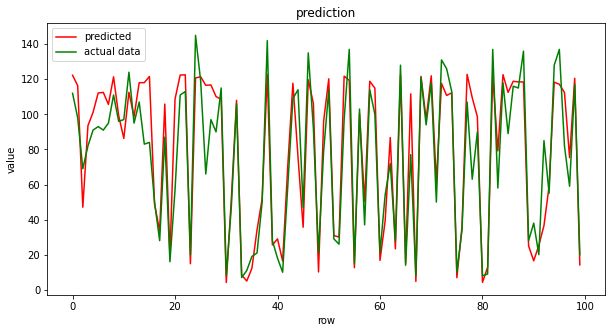

Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (17631, 30, 14)
(17631, 1)
Columns:  ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
Train size:  (10096, 30, 14)
(10096, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 1)             141

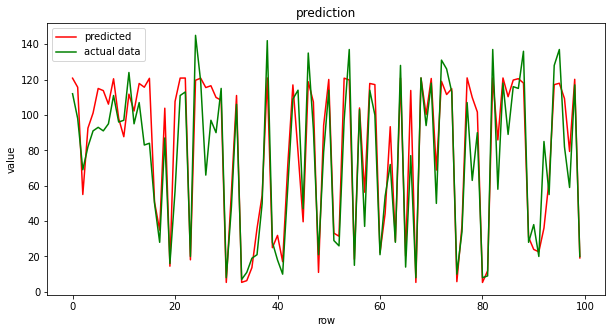

In [40]:
conv_layer_sizes = [1,2,3,4,5,6,7]
rmse_scores = []
for size in conv_layer_sizes:
    K.clear_session()
    x_train, y_train, sequence_cols = time_window_processing(train_df)

    model_dcnn = Sequential()
    if size==1:
        model_dcnn.add(Conv1D(1, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same", input_shape=(sequence_length, x_train.shape[2])))
        model_dcnn.add(Dropout(0.5))
        model_dcnn.add(Flatten())
        model_dcnn.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
        model_dcnn.add(Dense(y_train.shape[1])) 
        model_dcnn.summary()
    elif size==2:
        model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same", input_shape=(sequence_length, x_train.shape[2])))
        model_dcnn.add(Dropout(0.5))
        model_dcnn.add(Conv1D(1, kernel_size=3, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
        model_dcnn.add(Flatten())
        model_dcnn.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
        model_dcnn.add(Dense(y_train.shape[1])) 
        model_dcnn.summary()
    else:
        model_dcnn.add(Conv1D(1, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same", input_shape=(sequence_length, x_train.shape[2])))
        model_dcnn.add(Dropout(0.5))
        for i in range(2, size):
            model_dcnn.add(Conv1D(10, kernel_size=10, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
            model_dcnn.add(Dropout(0.5))
        model_dcnn.add(Conv1D(1, kernel_size=3, activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
        model_dcnn.add(Flatten())
        model_dcnn.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
        model_dcnn.add(Dense(y_train.shape[1])) 
        model_dcnn.summary()

    model_dcnn.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])   

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=200, min_lr=0.0001)
    history_dcnn = model_dcnn.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr],verbose=0)
    score, comp_score=predict_test(model_dcnn,test_df, RUL_FD001, sequence_cols)
    rmse_scores.append(scores)


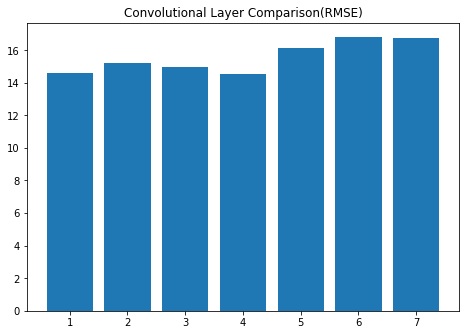

In [41]:
plot_experiment_comp(conv_layer_sizes, rmse_scores, "Convolutional Layer Comparison(RMSE)")

**30x14 filter**

In [ ]:
model_dcnn2 = Sequential()#add model layers
model_dcnn2.add(Conv2D(10, kernel_size=(sequence_length,x_train.shape[2]), activation='tanh', kernel_initializer=glorot_uniform, padding="same", input_shape=(sequence_length, x_train.shape[2], 1)))
model_dcnn2.add(Dropout(0.5))
model_dcnn2.add(Conv2D(10, kernel_size=(sequence_length,x_train.shape[2]), activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn2.add(Dropout(0.5))
model_dcnn2.add(Conv2D(10, kernel_size=(sequence_length,x_train.shape[2]), activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn2.add(Dropout(0.5))
model_dcnn2.add(Conv2D(10, kernel_size=(sequence_length,x_train.shape[2]), activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn2.add(Dropout(0.5))
model_dcnn2.add(Conv2D(1, kernel_size=(sequence_length,x_train.shape[2]), activation='tanh', kernel_initializer=glorot_uniform, padding="same"))
model_dcnn2.add(Flatten())
model_dcnn2.add(Dense(100, activation='tanh', kernel_initializer=glorot_uniform))
model_dcnn2.add(Dense(y_train.shape[1]))
model_dcnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 14, 10)        4210      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 14, 10)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 14, 10)        42010     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 14, 10)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 14, 10)        42010     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 14, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 14, 10)       

In [ ]:
#compile model using accuracy to measure model performance
model_dcnn2.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[root_mean_squared_error,competitive_score])

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=200, min_lr=0.0001)
history_dcnn2 = model_dcnn2.fit(x_train, y_train, batch_size=512, validation_split=0.05, epochs=250, callbacks=[reduce_lr])

Epoch 1/250
33/33 [==============================] - 3s 65ms/step - loss: 83.2993 - root_mean_squared_error: 83.2977 - competitive_score: 1580260.6728 - val_loss: 76.9055 - val_root_mean_squared_error: 75.8523 - val_competitive_score: 730780.0000
Epoch 2/250
33/33 [==============================] - 2s 60ms/step - loss: 76.5722 - root_mean_squared_error: 76.5719 - competitive_score: 799419.7279 - val_loss: 73.9726 - val_root_mean_squared_error: 72.9453 - val_competitive_score: 559267.5000
Epoch 3/250
33/33 [==============================] - 2s 60ms/step - loss: 73.6596 - root_mean_squared_error: 73.6588 - competitive_score: 612434.8015 - val_loss: 71.1255 - val_root_mean_squared_error: 70.1205 - val_competitive_score: 430473.0625
Epoch 4/250
33/33 [==============================] - 2s 60ms/step - loss: 70.9143 - root_mean_squared_error: 70.9134 - competitive_score: 474560.5671 - val_loss: 68.3350 - val_root_mean_squared_error: 67.3575 - val_competitive_score: 332430.2188
Epoch 5/250
33/

89/89 [==============================] - 1s 10ms/step - loss: 6.3433 - root_mean_squared_error: 6.3191 - competitive_score: 207.7568
RMSE: 6.319097518920898


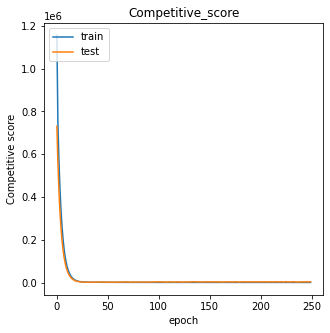

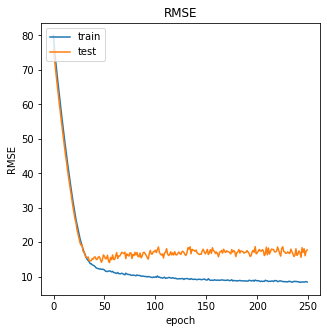

In [ ]:
plot_history(model_dcnn2,history_dcnn2)

In [ ]:
scores = model_dcnn2.evaluate(x_train, y_train, verbose=1, batch_size=200)
print("2D CNN score with filter size 30x14   :", scores[1])

89/89 [==============================] - 1s 9ms/step - loss: 6.3433 - root_mean_squared_error: 6.3191 - competitive_score: 207.7568
2D CNN score with filter size 30x14   : 6.319097518920898


In [ ]:
def predict_test_2D(model, test_df, label_df, sequence_cols, sequence_length=30):
    """
    Do prediction on model
    """
    y_true = label_df[0].to_numpy()
    y_true = np.asarray(y_true.reshape(y_true.shape[0],-1)).astype(float)
    print(y_true.shape)
    # We pick the last sequence for each id in the test data
    seq_array_test_last = [test_df[test_df['unit_number']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['unit_number'].unique() if len(test_df[test_df['unit_number']==id]) >= sequence_length]
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    seq_array_test_last = seq_array_test_last.reshape(seq_array_test_last.shape[0], seq_array_test_last.shape[1], seq_array_test_last.shape[2], 1)
    print(seq_array_test_last.shape)
    # test metrics

    score = model.evaluate(seq_array_test_last, y_true, verbose=2)
    print('\nRMSE: {}'.format(score[1]))
    print('\nScore: {}'.format(score[2]))
    y_pred = model.predict(seq_array_test_last)
    plot_compare_pred(y_pred,y_true)
    return score[1], score[2]

(100, 1)
(100, 30, 14, 1)
4/4 - 0s - loss: 15.9431 - root_mean_squared_error: 13.8353 - competitive_score: 102.7793

RMSE: 13.835278511047363

Score: 102.7792739868164


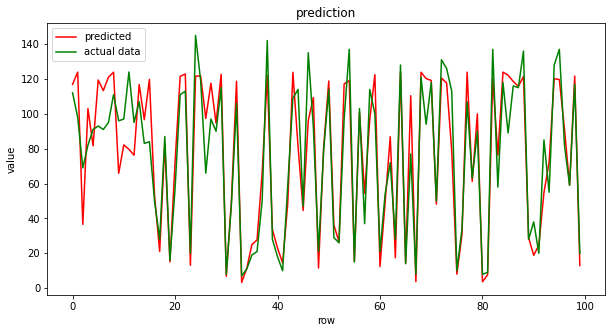

In [ ]:
dcnn2_score, dcnn2_comp_score=predict_test_2D(model_dcnn2,test_df, RUL_FD001, sequence_cols)